<a href="https://colab.research.google.com/github/lisosoma/BI_STATISTICS/blob/main/bi_hw2_6_add.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as sts
import scipy
import seaborn as sns
import scipy.optimize as opt
from scipy.optimize import fmin
import seaborn as sns

In [ ]:
df = pd.read_table('/content/IB_statistics_data_HW2.6.txt',sep='\s+', engine='python')

In [ ]:
df

,Ex1y,Ex1x_1,Ex1x_2
0,1.036541,-2.288539,-2.481673
1,13.428002,-0.705180,0.293510
2,77.876384,-0.333471,-0.444699
3,16.576600,0.246245,0.788285
4,2.123423,2.115068,1.691074
...,...,...,...
118,14.952383,0.971553,0.787756
119,11.305984,-0.438349,-0.790363
120,4.087781,2.101836,-4.398811
121,5.061741,2.015973,-4.277863


###  Задача 2.

In [ ]:
X = df.loc[:, 'Ex1x_1':'Ex1x_2'].to_numpy()
y = df['Ex1y'].to_numpy()

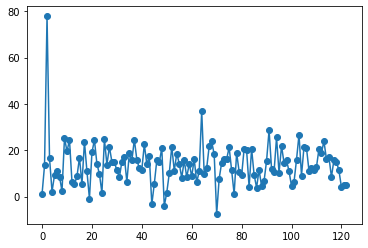

In [ ]:
plt.plot(y,  marker = 'o')

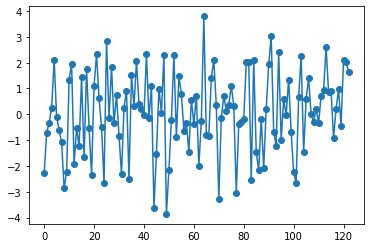

In [ ]:
plt.plot(X.T[0], marker = 'o')

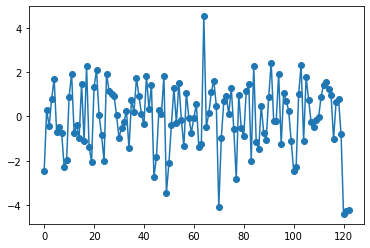

In [ ]:
plt.plot(X.T[1], marker = 'o')

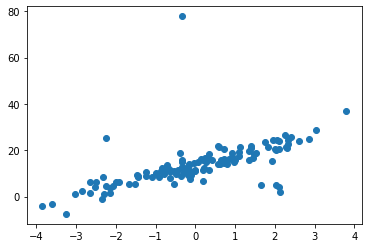

In [ ]:
plt.scatter(X.T[0], y)

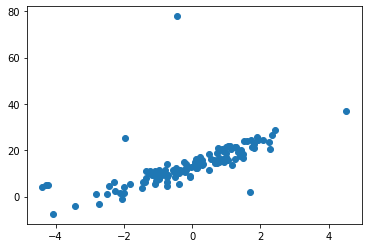

In [ ]:
plt.scatter(X.T[1], y)

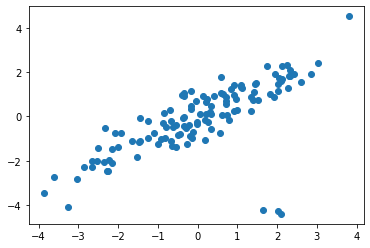

In [ ]:
plt.scatter(X.T[0], X.T[1])

- (a) 

Проверим наличие выбросов по межквартильным размахам.

In [ ]:
def IQR(x, name):
  xl, xu = x.quantile(q = 0.25), x.quantile(q = 0.75)
  idxl = np.where(x.to_numpy() < xl - 1.5 * (xu - xl))
  idxu = np.where(x.to_numpy() > xu + 1.5 * (xu - xl))
  return idxl, idxu

In [ ]:
yl, yu = IQR(y, 'y')
x1l, x1u = IQR(X.T[0], 'x1')
x1l, x1u = IQR(X.T[1], 'x2')

In [ ]:
yl, yu

((array([70]),), (array([ 2, 64]),))

In [ ]:
x1l, x1u

((array([], dtype=int64),), (array([], dtype=int64),))

In [ ]:
x1l, x1u

((array([], dtype=int64),), (array([], dtype=int64),))

По межквартильному размаху выбросами являются наблюдения с индексами 2, 64 и 70 в выборке $\mathbb{Y}$

- (b)

Воспользуемся критерием Граббса.

In [ ]:
!pip install outlier_utils

In [ ]:
from outliers import smirnov_grubbs as grubbs

Сначала проверим наличие выбросов в выборке $\mathbb{Y}$

In [ ]:
list(set(y)-set(grubbs.test(y, alpha=.05)))

[77.8763835376089]

In [ ]:
grubbs.max_test_indices(y, alpha=.05)

[2]

Максимальное значение выборки является выбросом.

Проверим наличие выбросов в выборке $\mathbb{X}$

In [ ]:
list(set(X.T[1])-set(grubbs.test(X.T[1], alpha=.05)))

[]

In [ ]:
list(set(X.T[2])-set(grubbs.test(X.T[2], alpha=.05)))

[]

Тест Граббса не обнаружил выбросы в выборке $\mathbb{X}$.

По тесту Граббса выбросами является наблюдение с номером 70 в выборке $\mathbb{Y}$.

- (c)

In [ ]:
xmean = np.array([np.mean(X.T[0]), np.mean(X.T[1])])

Посчитаем расстояние Махаланобиса для каждого регрессора

In [ ]:
sample1 = np.array([(x - xmean).T @ np.linalg.pinv(np.cov(X.T)) @ (x - xmean) for x in X])

Исходя из определений из лекции 19, $m = 2$, поэтому возьмем $\chi^2_{0.95}(2)$ как границу критической области для проверки гипотезы о наличии выбросов в регрессорах.

In [ ]:
np.where(sample1 > sts.chi2.ppf(q = 0.95, df = 2))[0]

array([ 49,  64,  70, 120, 121, 122])

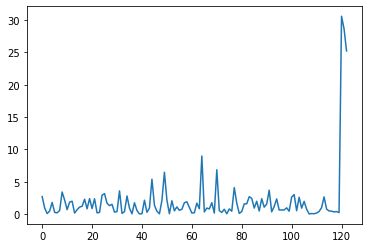

In [ ]:
plt.plot(sample1)

По расстоянию Махаланобиса выбросами среди регрессоров являются регрессоры с номерами 49,  64,  70, 120, 121, 122.

- (d)

In [ ]:
XY = df.to_numpy()
xymean = np.array([np.mean(XY.T[0]), np.mean(XY.T[1]), np.mean(XY.T[2])])

In [ ]:
sample2 = np.array([(xy - xymean).T @ np.linalg.pinv(np.cov(XY.T)) @ (xy - xymean) for xy in XY])

Исходя из определений из лекции 19, $m = 3$, поэтому возьмем $\chi^2_{0.95}(3)$ как границу критической области для проверки гипотезы о наличии выбросов в многмерной выборке.

In [ ]:
np.where(sample2 > sts.chi2.ppf(q = 0.95, df = 3))[0]

array([  2,   4,   9,  64, 120, 121, 122])

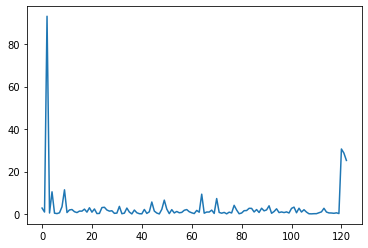

In [ ]:
plt.plot(sample2)

По расстоянию Махаланобиса выбросами являются наблюдения с номерами 2,   4,   9,  64, 120, 121, 122 в многомерной выборке.

- (e)

In [ ]:
X = np.array(np.concatenate(([np.ones(len(y))], X.T), axis=0)).T
beta = np.linalg.inv(X.T @ X) @ X.T @ y
sigma = sum((y - X @ beta) ** 2) / (len(y) - len(X.T))
covbeta = sigma * np.linalg.inv(X.T @ X)

In [ ]:
sample3 = []
for x in range(len(X)):
    X_ = list(X.copy())
    y_ = list(y.copy())
    X_.pop(x)
    y_.pop(x)
    X_ = np.array(X_)
    beta_ = np.linalg.inv(X_.T @ X_) @ X_.T @ y_
    sample3.append((beta - beta_).T @ np.linalg.pinv(np.cov(covbeta)) @ (beta - beta_) / 3)
sample3 = np.array(sample3)

In [ ]:
np.where(sample3 > 0.5)[0]

array([2])

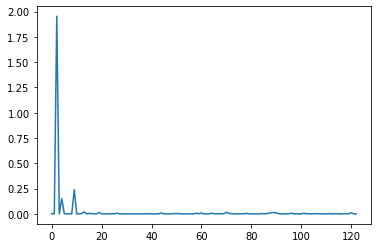

In [ ]:
plt.plot(sample3)

По расстоянию Кука выбросом являются наблюдение с номером 2.

Выбросами является наблюдение с номером 2, так как оно не прошло ни один тест. Также стоит обратить внимание на наблюдения с номерами 64, 70 и 120,  так как они не прошли несколько тестов.


### Задача 3.а.

Нормальные ошибки

In [ ]:
V = np.linspace(1, 3, 21)
mean = []

for v in V:
    deltav = []

    def minf(b):
        return np.sum(abs(yn - x.T @ b) ** v)

    for i in range(10000):
        x = sts.uniform.rvs(loc = -10, scale = 20, size = 70).T
        beta = np.array([2, -1])
        x = np.array(np.concatenate(([np.ones(70)], [x.T]), axis=0))
        yn = beta @ x + sts.norm.rvs(loc = 0, scale = 1, size = 70)

        deltav.append(np.linalg.norm(opt.minimize(minf, beta).x - beta))
    
    deltav = np.array(deltav)
    mean.append(np.mean(deltav))

mean = np.array(mean)

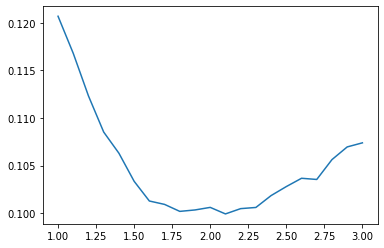

In [ ]:
plt.plot(V, mean)

Ошибки, имеющие распределение Лапласа.

In [ ]:
mean = []

for v in V:
    deltav = []

    def minf(b):
        return np.sum(abs(yn - x.T @ b) ** v)

    for i in range(10000):
        x = sts.uniform.rvs(loc = -10, scale = 20, size = 70).T
        beta = np.array([2, -1])
        x = np.array(np.concatenate(([np.ones(70)], [x.T]), axis=0))
        yn = beta @ x + sts.laplace.rvs(loc = 0, scale = 1 / np.sqrt(2), size = 70)

        deltav.append(np.linalg.norm(opt.minimize(minf, beta).x - beta))
    
    deltav = np.array(deltav)
    mean.append(np.mean(deltav))

mean = np.array(mean)

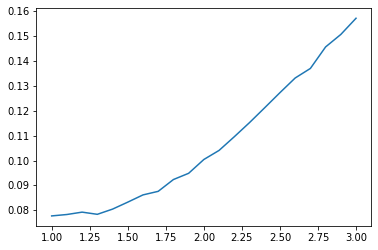

In [ ]:
plt.plot(V, mean)

Ошибки, имеющие распределение Коши.

In [ ]:
mean = []

for v in V:
    deltav = []

    def minf(b):
        return np.sum(abs(yn - x.T @ b) ** v)

    for i in range(10000):
        x = sts.uniform.rvs(loc = -10, scale = 20, size = 70).T
        beta = np.array([2, -1])
        x = np.array(np.concatenate(([np.ones(70)], [x.T]), axis=0))
        yn = beta @ x + sts.cauchy.rvs(loc = 0, scale = 1, size = 70)

        deltav.append(np.linalg.norm(opt.minimize(minf, beta).x - beta))
    
    deltav = np.array(deltav)
    mean.append(np.mean(deltav))

mean = np.array(mean)

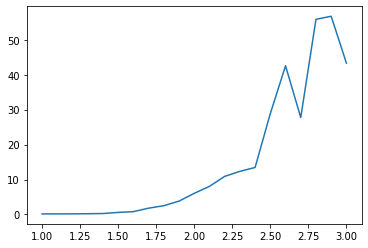

In [ ]:
plt.plot(V, mean)

Ошибки, имеющие равномерное распределение.

In [ ]:
mean = []

for v in V:
    deltav = []

    def minf(b):
        return np.sum(abs(yn - x.T @ b) ** v)

    for i in range(10000):
        x = sts.uniform.rvs(loc = -10, scale = 20, size = 70).T
        beta = np.array([2, -1])
        x = np.array(np.concatenate(([np.ones(70)], [x.T]), axis=0))
        yn = beta @ x + sts.uniform.rvs(loc = -np.sqrt(3), scale = 2 * np.sqrt(3), size = 70)

        deltav.append(np.linalg.norm(opt.minimize(minf, beta).x - beta))
    
    deltav = np.array(deltav)
    mean.append(np.mean(deltav))

mean = np.array(mean)

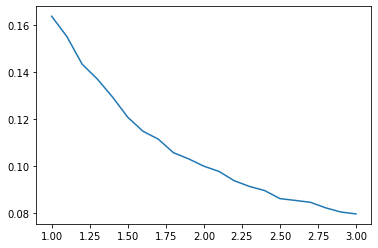

In [ ]:
plt.plot(V, mean)

Ошибки, имеющие указанную плотность. Сначала напишем функцию для моделирования выборки ошибок. Затем все то же самое, что и для предыдущих вариантов.

In [ ]:
q = lambda x : abs(x) * np.exp(- abs(x) ** 2.5 / 1.392105)  # плотность распределения
        
def p(s = 1):
    M = 0.5304
    
    distrib = []                  # список, где будут храниться значения случайной 
                                  # величины из распределения с плотностью q(x)   
        
    while(len(distrib) < s):      # пока размер списка не достигнет необходимого объема выборки
        
        uniform1 = sts.uniform.rvs(loc=0, scale=1, size=1, random_state=None)      # генерируем св ~ U[0, 1]
        uniformb = sts.uniform.rvs(loc=0, scale=1, size=1, random_state=None)      # генерируем еще одну такую же св
                                                                                   # она служит для того, чтобы определить
                                                                                   # знак св uniform1 
                
        if uniformb >= 1 / 2:      # определяем знак, таким образом получаем uniform1' ~ U[-1, 1]
            uniform1 *= -1
            
        uniform2 = sts.uniform.rvs(loc=0, scale=1, size=1, random_state=None)      # генерируем еще одну св ~ U[0, 1]
        if uniform2 * M <= q(uniform1 * np.sqrt(2)):                             # проверяем условие того, что
                                                                                   # если uniform2 *  M ~ U[0, M]
                                                                                   # коордианата y точки с координатой
                                                                                   # x = uniform1'', которая попадает
                                                                                   # под график q(x), то тогда искомая
            distrib.append(float(uniform1 * np.sqrt(2)))                         # св равна uniform1''
    return np.array(distrib)

In [ ]:
mean = []

for v in V:
    deltav = []

    def minf(b):
        return np.sum(abs(yn - x.T @ b) ** v)

    for i in range(10000):
        x = sts.uniform.rvs(loc = -10, scale = 20, size = 70).T
        beta = np.array([2, -1])
        x = np.array(np.concatenate(([np.ones(70)], [x.T]), axis=0))
        yn = beta @ x + p(70)

        deltav.append(np.linalg.norm(opt.minimize(minf, beta).x - beta))
    
    deltav = np.array(deltav)
    mean.append(np.mean(deltav))

mean = np.array(mean)

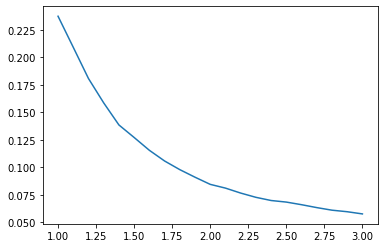

In [ ]:
plt.plot(V, mean)

Ошибки, имеющие распределение Стьюдента с 70 степенями свободы.

In [ ]:
mean = []

for v in V:
    deltav = []

    def minf(b):
        return np.sum(abs(yn - x.T @ b) ** v)

    for i in range(10000):
        x = sts.uniform.rvs(loc = -10, scale = 20, size = 70).T
        beta = np.array([2, -1])
        x = np.array(np.concatenate(([np.ones(70)], [x.T]), axis=0))
        yn = beta @ x + sts.t.rvs(df = 70, loc=0, scale=1, size=70)

        deltav.append(np.linalg.norm(opt.minimize(minf, beta).x - beta))
    
    deltav = np.array(deltav)
    mean.append(np.mean(deltav))

mean = np.array(mean)

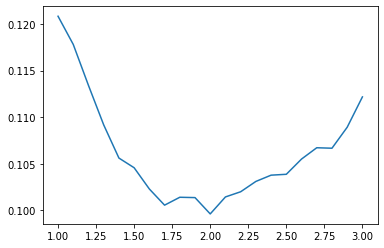

In [ ]:
plt.plot(V, mean)

### Задача 3.b

Возьмем функции $|x|^2, \ |x|^3$ и функцию Рамсея. Ошибки -- с распределением Коши, Лапласа и равномерным распределением.

Сначала для ошибок с равномерным распределением.

In [ ]:
P = np.linspace(0, 1, 21)
mean1, mean2, mean3 = [], [], []

for p in P:
    deltav1, deltav2, deltav3 = [], [], []

    def errors(p):
        un = sts.uniform.rvs(size = 70)
        er = []
        for u in un:
            if u <= p:
                er.append(float(sts.norm.rvs(loc = 0, scale = 1, size = 1)))
            else:
                er.append(float(sts.uniform.rvs(loc = 0, scale = 1, size = 1)))
        return er

    def minols(b):
        return np.sum(abs(yn - x.T @ b) ** 2)

    def minf(b):
        return np.sum(abs(yn - x.T @ b) ** 3)

    def minfram(b):
        return np.sum(9 * (1 - (1 + abs(yn - x.T @ b) / 3) * np.exp(- abs(yn - x.T @ b) / 3)))

    for i in range(10000):
        x = sts.uniform.rvs(loc = -10, scale = 20, size = 70).T
        beta = np.array([2, -1])
        x = np.array(np.concatenate(([np.ones(70)], [x.T]), axis=0))
        yn = beta @ x + errors(p)

        deltav1.append(np.linalg.norm(opt.minimize(minols, beta).x - beta))
        deltav2.append(np.linalg.norm(opt.minimize(minf, beta).x - beta))
        deltav3.append(np.linalg.norm(opt.minimize(minfram, beta).x - beta))
    
    deltav1 = np.array(deltav1)
    deltav2 = np.array(deltav2)
    deltav3 = np.array(deltav3)
    mean1.append(np.mean(deltav1))
    mean2.append(np.mean(deltav2))
    mean3.append(np.mean(deltav3))

mean1 = np.array(mean1)
mean2 = np.array(mean2)
mean3 = np.array(mean3)

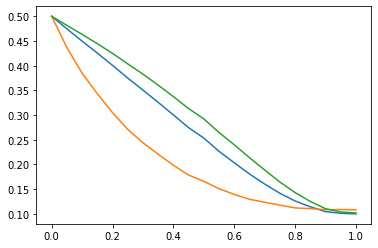

In [ ]:
plt.plot(P, mean1)
plt.plot(P, mean2)
plt.plot(P, mean3)

Затем с распределением Коши

In [ ]:
P = np.linspace(0, 1, 21)
mean1, mean2, mean3 = [], [], []

for p in P:
    deltav1, deltav2, deltav3 = [], [], []

    def errors(p):
        un = sts.uniform.rvs(size = 70)
        er = []
        for u in un:
            if u <= p:
                er.append(float(sts.norm.rvs(loc = 0, scale = 1, size = 1)))
            else:
                er.append(float(sts.cauchy.rvs(loc = 0, scale = 1, size = 1)))
        return er

    def minols(b):
        return np.sum(abs(yn - x.T @ b) ** 2)

    def minf(b):
        return np.sum(abs(yn - x.T @ b) ** 3)

    def minfram(b):
        return np.sum(9 * (1 - (1 + abs(yn - x.T @ b) / 3) * np.exp(- abs(yn - x.T @ b) / 3)))

    for i in range(10000):
        x = sts.uniform.rvs(loc = -10, scale = 20, size = 70).T
        beta = np.array([2, -1])
        x = np.array(np.concatenate(([np.ones(70)], [x.T]), axis=0))
        yn = beta @ x + errors(p)

        deltav1.append(np.linalg.norm(opt.minimize(minols, beta).x - beta))
        deltav2.append(np.linalg.norm(opt.minimize(minf, beta).x - beta))
        deltav3.append(np.linalg.norm(opt.minimize(minfram, beta).x - beta))
    
    deltav1 = np.array(deltav1)
    deltav2 = np.array(deltav2)
    deltav3 = np.array(deltav3)
    mean1.append(np.mean(deltav1))
    mean2.append(np.mean(deltav2))
    mean3.append(np.mean(deltav3))

mean1 = np.array(mean1)
mean2 = np.array(mean2)
mean3 = np.array(mean3)

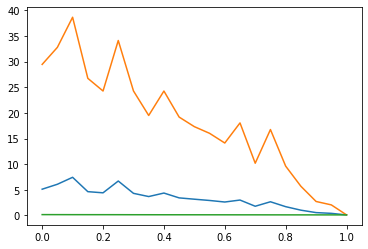

In [ ]:
plt.plot(P, mean1)
plt.plot(P, mean2)
plt.plot(P, mean3)

И с распределением Лапласа.

In [ ]:
P = np.linspace(0, 1, 21)
mean1, mean2, mean3 = [], [], []

for p in P:
    deltav1, deltav2, deltav3 = [], [], []

    def errors(p):
        un = sts.uniform.rvs(size = 70)
        er = []
        for u in un:
            if u <= p:
                er.append(float(sts.norm.rvs(loc = 0, scale = 2, size = 1)))
            else:
                er.append(float(sts.uniform.rvs(loc = 0, scale = 1, size = 1)))
        return er

    def minols(b):
        return np.sum(abs(yn - x.T @ b) ** 2)

    def minf(b):
        return np.sum(abs(yn - x.T @ b) ** 3)

    def minfram(b):
        return np.sum(9 * (1 - (1 + abs(yn - x.T @ b) / 3) * np.exp(- abs(yn - x.T @ b) / 3)))

    for i in range(10000):
        x = sts.uniform.rvs(loc = -10, scale = 20, size = 70).T
        beta = np.array([2, -1])
        x = np.array(np.concatenate(([np.ones(70)], [x.T]), axis=0))
        yn = beta @ x + errors(p)

        deltav1.append(np.linalg.norm(opt.minimize(minols, beta).x - beta))
        deltav2.append(np.linalg.norm(opt.minimize(minf, beta).x - beta))
        deltav3.append(np.linalg.norm(opt.minimize(minfram, beta).x - beta))
    
    deltav1 = np.array(deltav1)
    deltav2 = np.array(deltav2)
    deltav3 = np.array(deltav3)
    mean1.append(np.mean(deltav1))
    mean2.append(np.mean(deltav2))
    mean3.append(np.mean(deltav3))

mean1 = np.array(mean1)
mean2 = np.array(mean2)
mean3 = np.array(mean3)

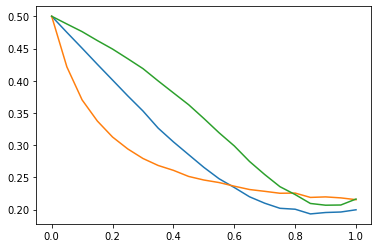

In [ ]:
plt.plot(P, mean1)
plt.plot(P, mean2)
plt.plot(P, mean3)

Синим цветом на графиках изображены разности, испльзующие для оценки функции $p(x) = |x|^2$, зеленым -- $|x|^3$, оранжевым - Рамсея.

### Задача 1.

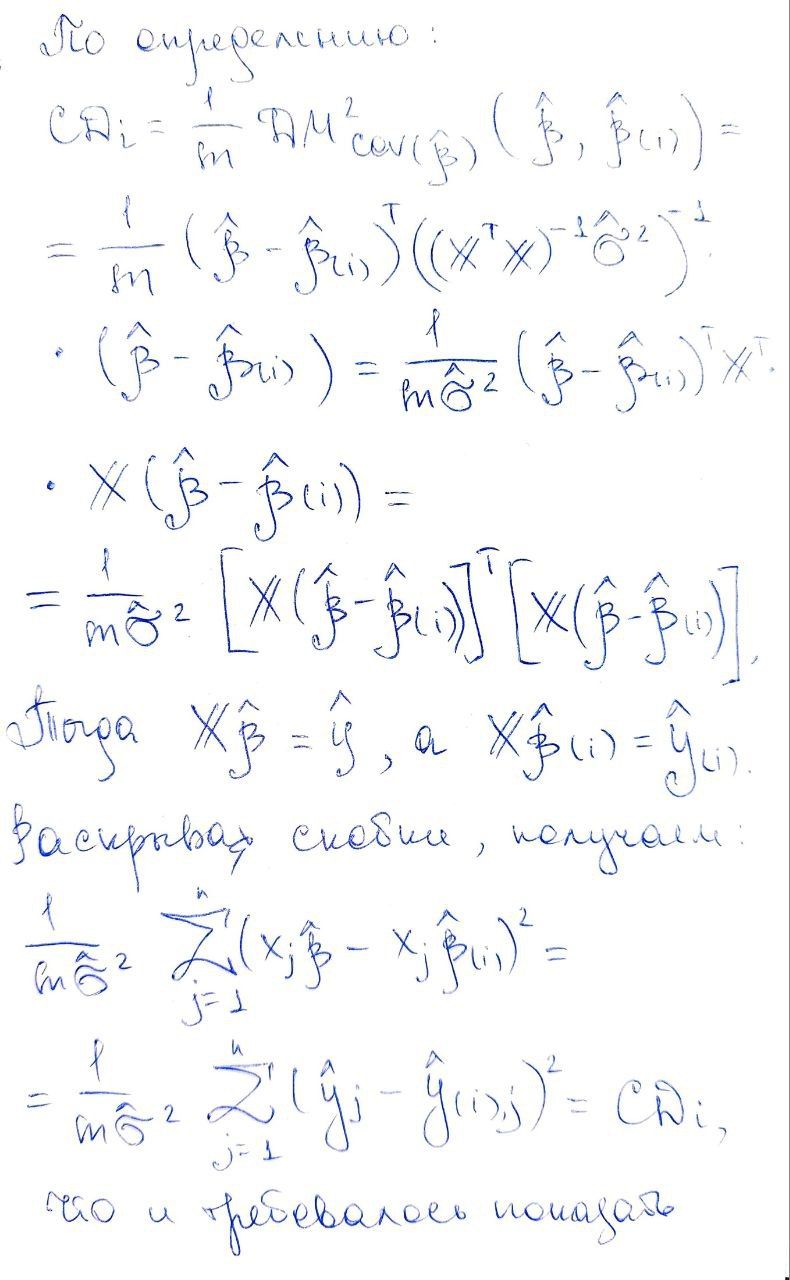